# Exploratory data analysis

#### Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

import numpy as np
import pandas as pd
import re
import string
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import stop_words

from pymystem3 import Mystem

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.simplefilter('ignore')

#### Load and prepare dataset

#### Source of data:
https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/

In [2]:
%%time
data = pd.read_csv('./data/lenta-ru-news.csv', parse_dates=['date'])

Wall time: 20.1 s


In [3]:
# the first row
data.iloc[0].values

array(['https://lenta.ru/news/1914/09/16/hungarnn/',
       '1914. Русские войска вступили в\xa0пределы Венгрии  ',
       'Бои у Сопоцкина и Друскеник закончились отступлением германцев. Неприятель, приблизившись с севера к Осовцу начал артиллерийскую борьбу с крепостью. В артиллерийском бою принимают участие тяжелые калибры. С раннего утра 14 сентября огонь достиг значительного напряжения. Попытка германской пехоты пробиться ближе к крепости отражена. В Галиции мы заняли Дембицу. Большая колонна, отступавшая по шоссе от Перемышля к Саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. Вылазки гарнизона Перемышля остаются безуспешными. При продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. На перевале Ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы Венгрии. \n«Русский инвали

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   url     800975 non-null  object        
 1   title   800975 non-null  object        
 2   text    800970 non-null  object        
 3   topic   738973 non-null  object        
 4   tags    773756 non-null  object        
 5   date    800975 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 36.7+ MB


In [5]:
# missing data
round((len(data) - data.count()) / len(data) * 100, 2).sort_values(ascending=False)

topic    7.74
tags     3.40
date     0.00
text     0.00
title    0.00
url      0.00
dtype: float64

#### Removing the missing data

In [6]:
data = data.dropna()

In [7]:
# number of categories
data.nunique().sort_values(ascending=False)

url      712643
text     711725
title    710040
date       7029
tags         88
topic        23
dtype: int64

#### Tags

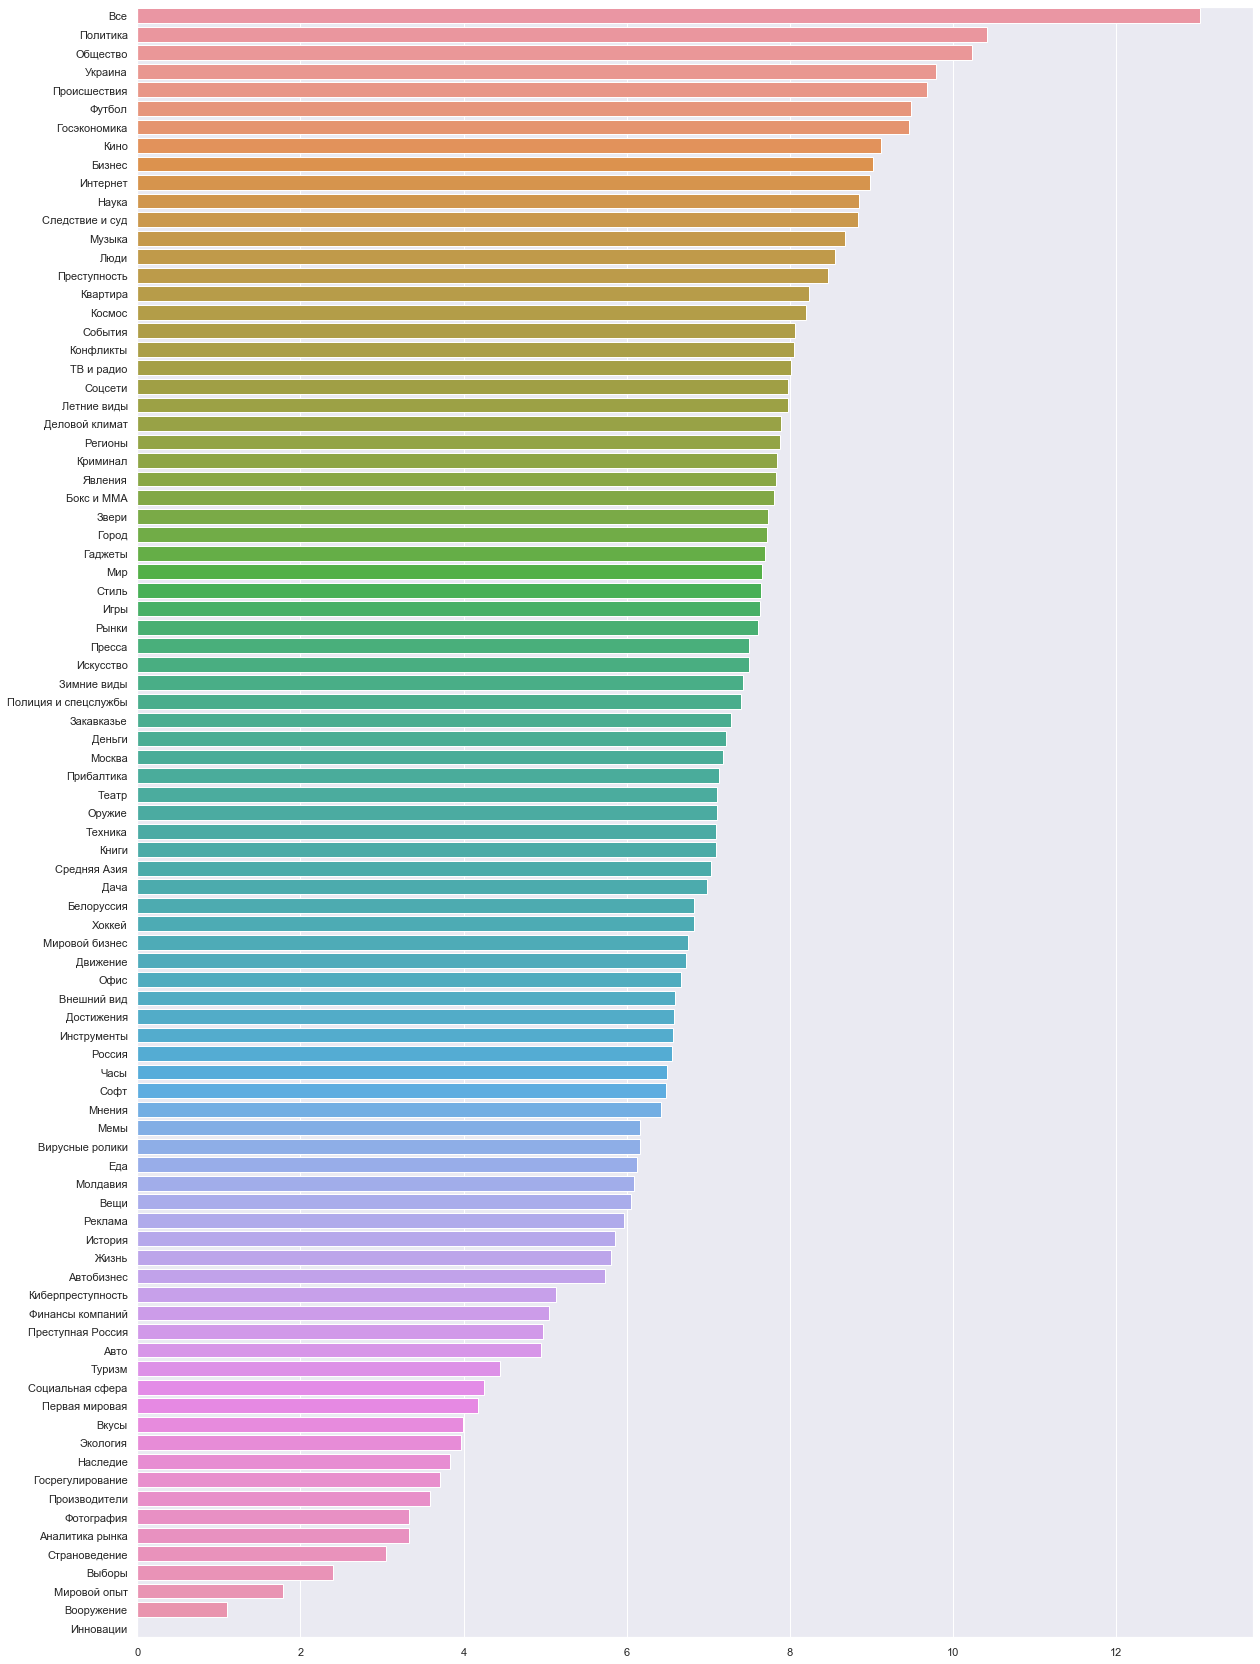

In [8]:
# log because the difference between most common and most unpopular tags is enourmous
plt.figure(figsize=(20,30))
sns.barplot(x=np.log(data.tags.value_counts().values), y=data.tags.value_counts().index);

#### Topics

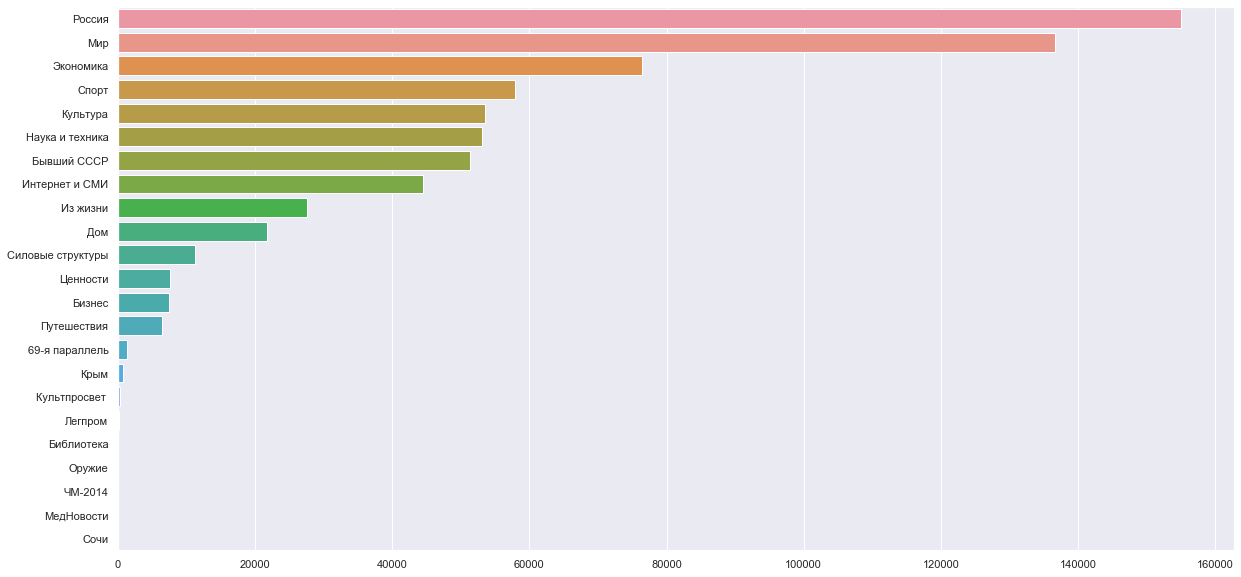

In [9]:
plt.figure(figsize=(20,10))
sns.barplot(x=data.topic.value_counts().values, y=data.topic.value_counts().index);

In [10]:
table = pd.crosstab(data.tags, data.topic)
table

topic,69-я параллель,Библиотека,Бизнес,Бывший СССР,Дом,Из жизни,Интернет и СМИ,Крым,Культпросвет,Культура,...,Наука и техника,Оружие,Путешествия,Россия,Силовые структуры,Сочи,Спорт,Ценности,ЧМ-2014,Экономика
tags,,,,,,,,,,,,,,,,,,,,,
Coцсети,0,0,0,0,0,0,2924,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Авто,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,141,0,0,0
Автобизнес,0,0,310,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Аналитика рынка,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Белоруссия,0,0,0,916,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Футбол,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,13128,0,0,0
Хоккей,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,915,0,0,0
Часы,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,662,0,0


In [11]:
data['sub_topics'] = data.topic + '_' + data.tags
data['sub_topics'].value_counts()

Россия_Все             111884
Мир_Все                 95125
Экономика_Все           55252
Спорт_Все               36697
Наука и техника_Все     34537
                        ...  
ЧМ-2014_Все                 2
Легпром_Все                 2
Сочи_Все                    1
МедНовости_Все              1
Легпром_Инновации           1
Name: sub_topics, Length: 122, dtype: int64

#### Top 20 sub-topics

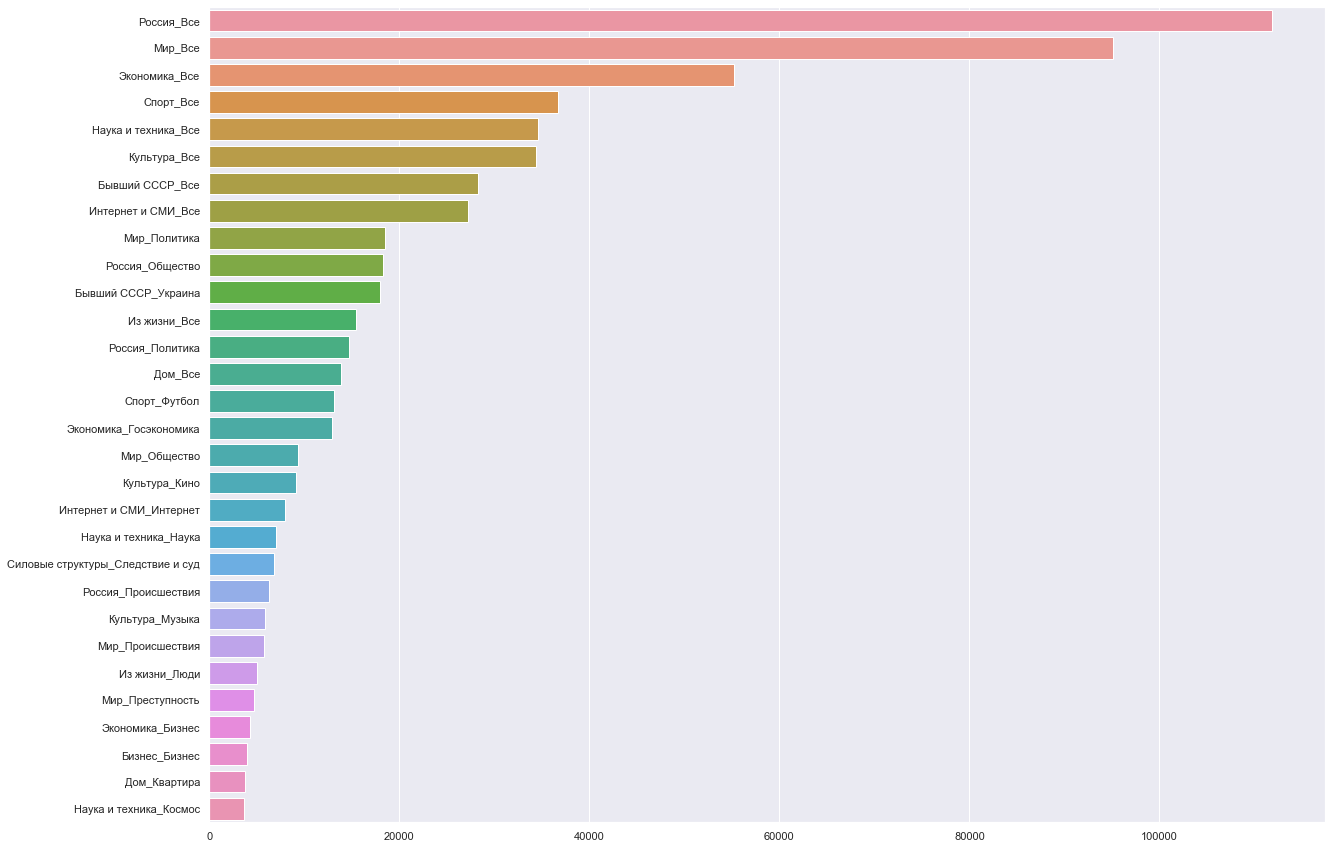

In [12]:
plt.figure(figsize=(20,15))
sns.barplot(x=data.sub_topics.value_counts().head(30).values, y=data.sub_topics.value_counts().head(30).index);

#### Removing the texts on unpopular sub-topics

In [13]:
pop_sub_topics = data.sub_topics.value_counts().head(30).index
data = data.loc[data['sub_topics'].isin(pop_sub_topics)]
data.shape

(631314, 7)

#### Calculating the number of words, unique words, stop-words, mean words' length, chars and punctuation marks

In [14]:
data.text = data.text.str.lower()

In [15]:
STOPWORDS = set(stop_words.get_stop_words('ru'))
PUNCT = set(string.punctuation)

In [16]:
%%time
# word_count
data['word_count'] = data['text'].apply(
    lambda x: len(str(x).split())
)

# unique_word_count
data['unique_word_count'] = data['text'].apply(
    lambda x: len(set(str(x).split()))
)

# stop_word_count
data['stop_word_count'] = data['text'].apply(
    lambda x: len([w for w in str(x).split() if w in STOPWORDS])
)

# mean_word_length
data['mean_word_length'] = data['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()])
)

# char_count
data['char_count'] = data['text'].apply(
    lambda x: len(str(x))
)

# punctuation_count
data['punctuation_count'] = data['text'].apply(
    lambda x: len([c for c in str(x) if c in PUNCT])
)

Wall time: 2min 18s


### Anomaly detection

In [17]:
data.describe()

,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
count,631314.000000,631314.000000,631314.000000,631314.000000,631314.000000,631314.000000
mean,180.783444,142.827287,50.581863,6.422603,1337.985186,37.207247
std,75.988088,49.849078,24.035622,0.486432,564.459582,19.555004
min,1.000000,1.000000,0.000000,2.500000,3.000000,0.000000
25%,132.000000,109.000000,35.000000,6.132296,974.000000,25.000000
50%,171.000000,138.000000,47.000000,6.410256,1261.000000,34.000000
75%,218.000000,171.000000,62.000000,6.691983,1613.000000,45.000000
max,8092.000000,3716.000000,3159.000000,50.000000,55387.000000,1799.000000


Obviously, there are some outliers in the dataset.

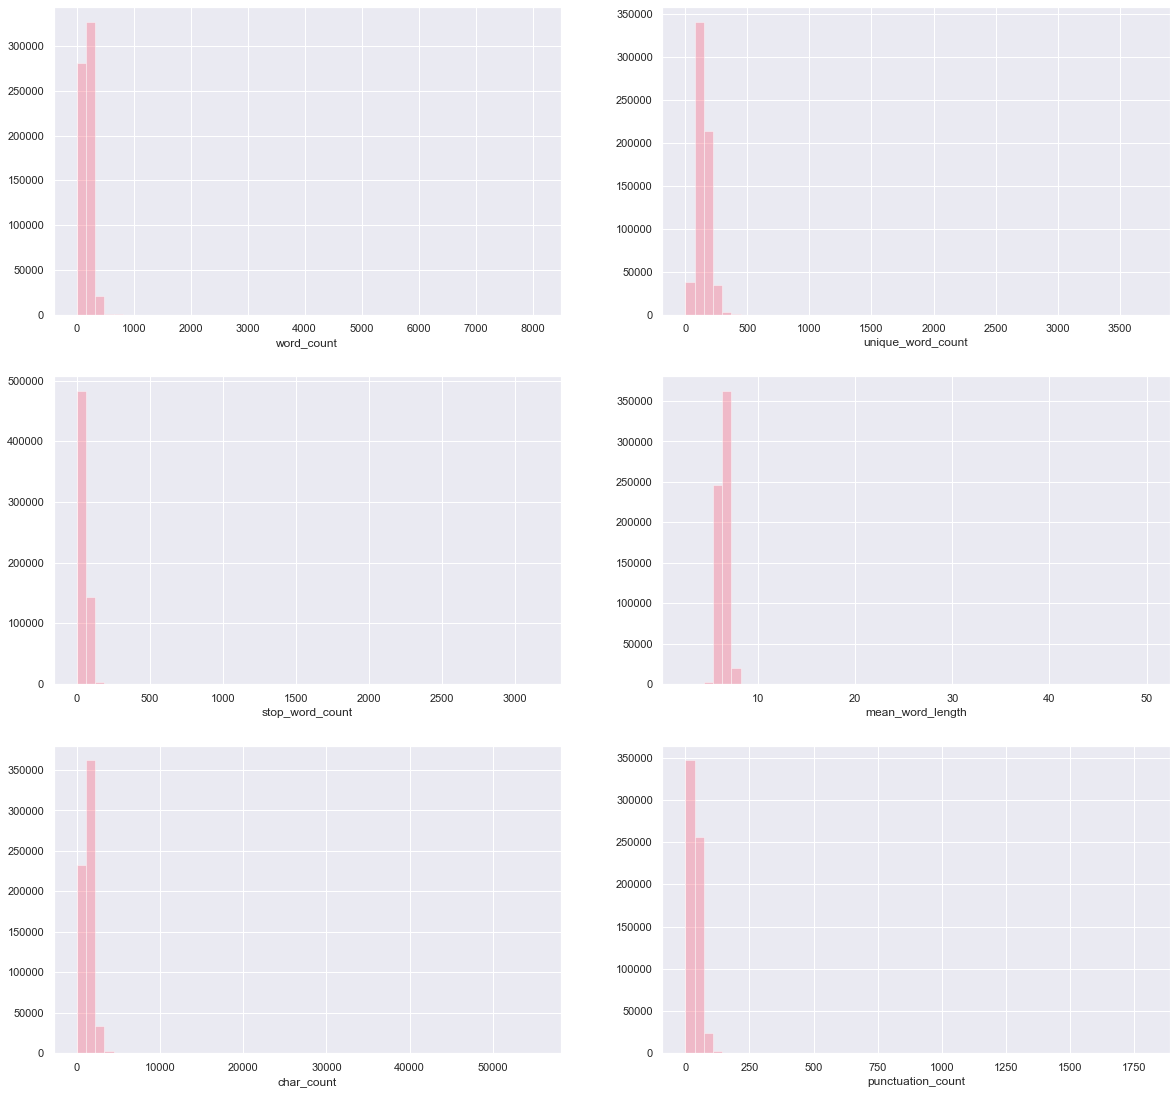

In [18]:
METAFEATURES = ['word_count', 
                'unique_word_count', 
                'stop_word_count', 
                'mean_word_length',
                'char_count', 
                'punctuation_count']
  
plt.figure(figsize=(20,60))

for i, colname in enumerate(METAFEATURES):
    plt.subplot(9,2,i+1)
    sns.distplot(data[colname], kde=False)
    
plt.show()

In [19]:
word_count_qu_01 = data['word_count'].quantile(0.01)
word_count_qu_99 = data['word_count'].quantile(0.99)
word_count_qu_01, word_count_qu_99

(53.0, 399.0)

In [20]:
mean_word_length_qu_01 = data['mean_word_length'].quantile(0.01)
mean_word_length_qu_99 = data['mean_word_length'].quantile(0.99)
mean_word_length_qu_01, mean_word_length_qu_99

(5.458015267175573, 7.521367521367521)

In [21]:
punctuation_count_qu_01 = data['punctuation_count'].quantile(0.01)
punctuation_count_qu_99 = data['punctuation_count'].quantile(0.99)
punctuation_count_qu_01, punctuation_count_qu_99

(10.0, 100.0)

#### Removing the texts which are out of the 1-99 quartile range

In [22]:
data = data.loc[data['word_count'].between(
    word_count_qu_01, word_count_qu_99
)]

In [23]:
data = data.loc[data['mean_word_length'].between(
    mean_word_length_qu_01, mean_word_length_qu_99
)]

In [25]:
data = data.loc[data['punctuation_count'].between(
    punctuation_count_qu_01, punctuation_count_qu_99
)]

In [26]:
data.shape

(603321, 13)

In [28]:
data.columns

Index(['url', 'title', 'text', 'topic', 'tags', 'date', 'sub_topics',
       'word_count', 'unique_word_count', 'stop_word_count',
       'mean_word_length', 'char_count', 'punctuation_count'],
      dtype='object')

In [29]:
data = data[['text', 'topic', 'sub_topics']]

#### Saving the data

In [30]:
data.to_csv('train_data.csv', index=False)